<a href="https://colab.research.google.com/github/AlexandreAdam/torch_score_models/blob/master/score_based_modeling_overview_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
#@title Utility functions
!pip install torchquad --quiet

%matplotlib inline

import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
plt.style.use("seaborn-v0_8")

params = {
    'legend.fontsize': 20,
    'figure.figsize': (5, 5),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 20 # for annotate
}
pylab.rcParams.update(params)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
!pip install score_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [7]:
#@title Additional imports
from score_models import ScoreModel, MLP
from torch.utils.data import Dataset

In [114]:
#@title Create 1D Gaussian Distribution
mu = 0 # mean centered at 0
sigma = 1 # unit standard deviation
num_points = 2000

class GaussianDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dist = np.random.normal(mu, sigma, num_points)
dataset = GaussianDataset(dist)
dimensions = 1
bins = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 20)

In [115]:
dataset.data.shape

torch.Size([2000, 1])

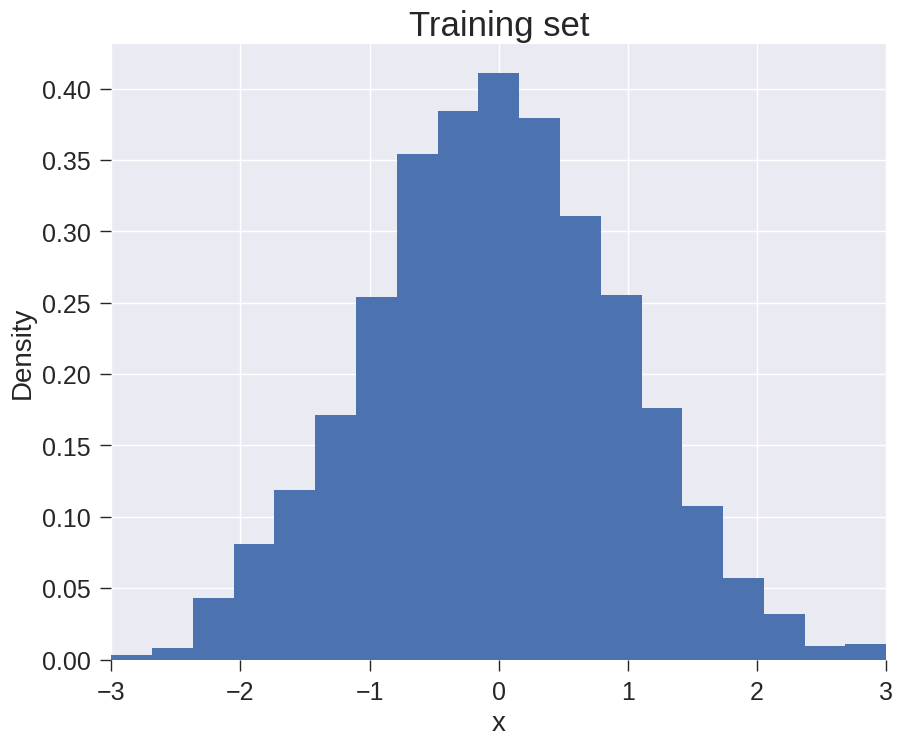

In [116]:
#Plot the training set
figure = plt.figure(figsize=(10, 8))
plt.hist(dist, bins=bins, density=True)
plt.title("Training set")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(mu - 3 * sigma, mu + 3 * sigma)
plt.show()

In [117]:
C = 1 # one channel 1D distribution
B = 128 # batch size
checkpoints_directory = "checkpoints"
net = MLP(channels=C, dimensions=dimensions, units=50, layers=4)
model = ScoreModel(model=net, sigma_min=1e-2, sigma_max=10, device=DEVICE)

Using the Variance Exploding SDE


In [118]:
losses = model.fit(dataset, epochs=200, batch_size=B, learning_rate=1e-3, checkpoints_directory=None)

Epoch 200 | Cost: 6.9e-01 |: 100%|██████████| 200/200 [00:25<00:00,  7.84it/s]

Finished training after 0.007 hours.


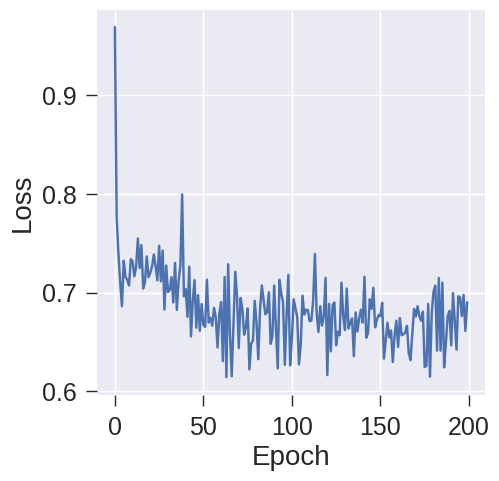

In [119]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [120]:
#Takes about 10 seconds to sample using 1000 steps
num_samples = 1000
num_steps = 1000
samples = model.sample(shape=[1000, 1], steps=num_steps)

Sampling from the prior | t = 0.0 | sigma = 1.0e-02| scale ~ 1.0e+00: 100%|██████████| 1000/1000 [00:08<00:00, 117.35it/s]


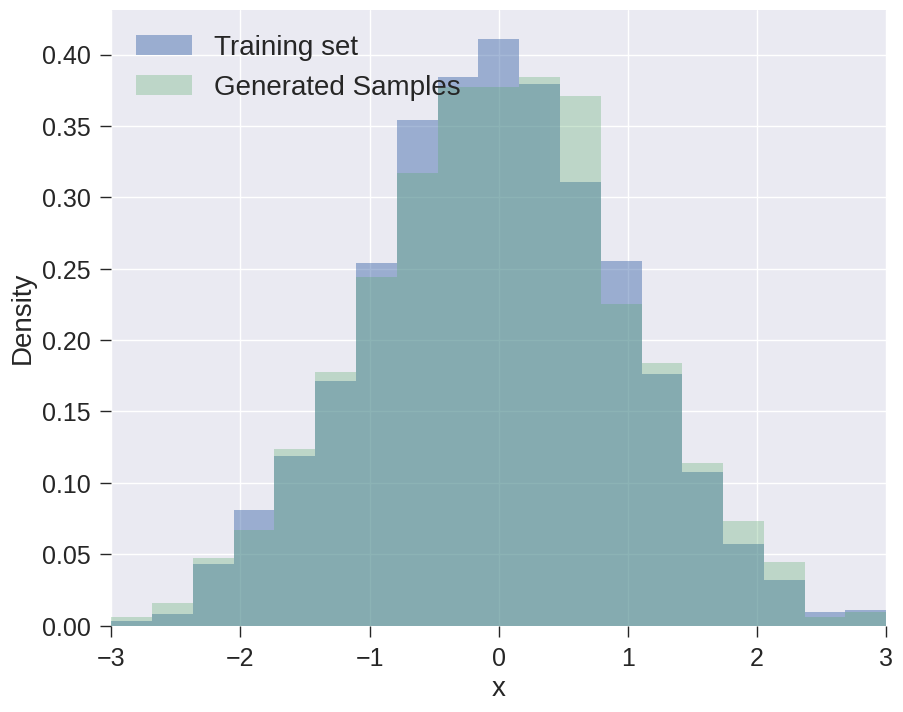

In [121]:
#@title Plot the generated samples

figure = plt.figure(figsize=(10, 8))
plt.hist(dist, bins=bins, density=True, alpha=0.5, label="Training set")
plt.hist(samples.squeeze().cpu(), bins=bins, alpha=0.3, density=True, label="Generated Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(mu - 3 * sigma, mu + 3 * sigma)
plt.legend(frameon=False)
plt.show()